In [0]:
## Import required packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import warnings
warnings.simplefilter("ignore")

In [3]:
## Initializing dask for parallel computing
from dask.distributed import Client, progress
# if __name__ == "__main__":
# client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35611 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 13.65 GB


In [4]:
### Used to view the Dask dashboard in Google Colab
## Comment out if not required
# ! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip ngrok-stable-linux-amd64.zip

get_ipython().system_raw('./ngrok http 8787 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://b1efae7c4efe.ngrok.io


In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [0]:
df_psl=df.query("table_id=='Amon' & experiment_id == 'hist-aer' & variable_id=='psl'")
df_psl_ssp=df.query("table_id=='Amon' & experiment_id == 'ssp245-aer' & variable_id=='psl'")

In [9]:
df_psl.groupby(['source_id'])['zstore'].count()

source_id
BCC-CSM2-MR         3
CESM2               1
CNRM-CM6-1         10
CanESM5            30
GFDL-ESM4           1
GISS-E2-1-G         5
HadGEM3-GC31-LL     4
IPSL-CM6A-LR       10
MIROC6              3
MRI-ESM2-0          3
Name: zstore, dtype: int64

In [10]:
## Getting all the common models between historical and ssp245 experiments
amoc_models = models=['MIROC6', 'NorESM2-LM', 'IPSL-CM6A-LR', 'HadGEM3-GC31-LL',
       'BCC-CSM2-MR', 'CNRM-CM6-1', 'CanESM5', 'CESM2']
common_models = np.intersect1d(list(df_psl['source_id'].unique()),amoc_models)
# models_ssp = np.intersect1d(list(df_psl_ssp['source_id'].unique()),amoc_models)
# common_models=list(set(models_ssp) & set(models_hist))
common_models

array(['BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'HadGEM3-GC31-LL',
       'IPSL-CM6A-LR', 'MIROC6'], dtype='<U15')

In [0]:
def get_data(source_id, expt_id, exp2='ssp245-aer'):
  '''
  1) Loads data using zarr from Google cloud 
  2) combines historical with ssp245
  '''
  rlzn = df_psl['member_id'][df_psl.source_id == source_id].values
  ds_r=[0]*len(rlzn)
  m=0
  for r in rlzn:
    uri = df_psl[(df_psl.source_id == source_id) & (df_psl.experiment_id == 'hist-aer') & (df_psl.member_id == r)].zstore.values[0]
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds_r[m] = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    m=m+1
  ds = sum(ds_r)/m
  return ds

def get_lon(val):
    '''
    Converts data to 180W to 180E longitude format
    '''
    lon=(((val.lon + 180) % 360) - 180)
    val.coords['lon']=lon
    val = val.sortby(val.lon)
    return val

def get_EOF(model):
  '''
  Calculates EOF1 and PC1 from SLP data
  '''
  ds=get_data(model, expt_id='hist-aer')['psl'].sel(time=slice('1899', '2020')).load()*.01
  try:
    ds = ds.rename({'longitude':'lon','latitude':'lat'})
  except:
    pass
  ds_lon = get_lon(ds)
  atl = (ds_lon).sel(lon=slice(-90,40),lat=slice(20,80))
  clim = atl.groupby('time.month').mean('time')
  anom = atl.groupby('time.month') - clim
  ds_DJFM = anom.where((anom['time.month'] == 12) | (anom['time.month'] == 1) | (anom['time.month'] == 2) | (anom['time.month'] == 3))
  ds_DJFM = ds_DJFM.rolling(min_periods=4, center=True, time=4).mean()
  ds_DJFM = ds_DJFM.groupby('time.year').mean('time')
  ds_DJFM=ds_DJFM.rename({'year':'time'})
  coslat = np.cos(np.deg2rad(ds_DJFM.coords['lat'].values)).clip(0., 1.)
  wgts = np.sqrt(coslat)[..., np.newaxis]
  solver_djfm = Eof(ds_DJFM[1:], weights=wgts)
  pc_djfm = solver_djfm.pcs(npcs=1, pcscaling=1)
  # Retrieve the leading EOF, expressed as the covariance between the leading PC
  # time series and the input SLP anomalies at each grid point.
  eof1 = solver_djfm.eofsAsCovariance(neofs=1)
  return eof1, pc_djfm.to_dataframe()['pcs'].values

def get_plot(eof1,model,axs):
  '''
  Plots EOF1
  '''
  clevs = np.linspace(-6., 6., 11)
  eof1[0].plot.contourf(ax=axs, level=clevs, cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(), add_colorbar=False)
  axs.set_title(model)

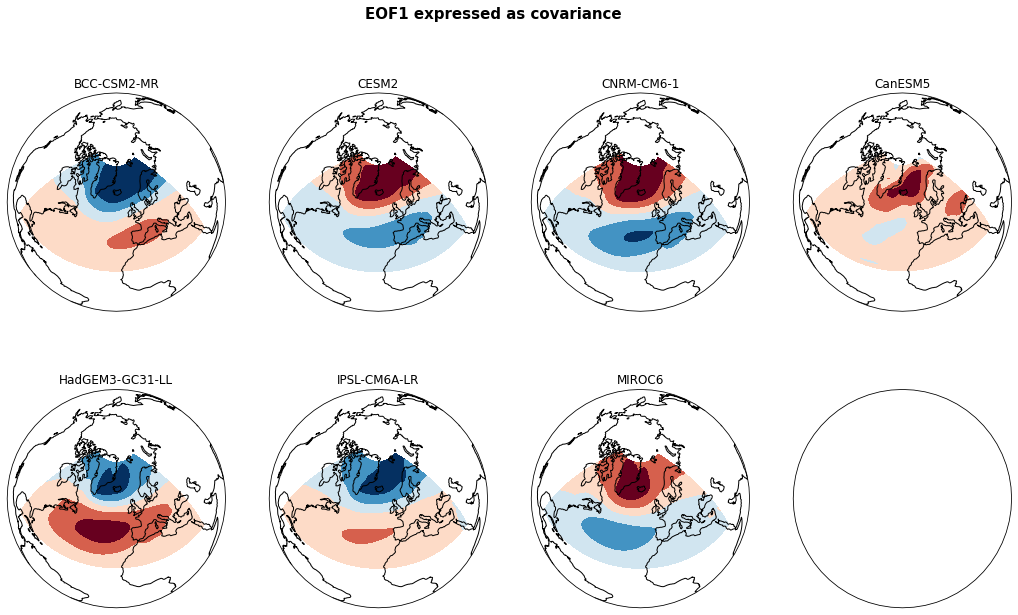

In [121]:
## Plot the leading EOF expressed as covariance in the European/Atlantic domain.
proj = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
fig, axs = plt.subplots(2,4,figsize=[18,10],subplot_kw=dict(projection=proj))
fig.suptitle('EOF1 expressed as covariance',fontsize=15,weight='bold')
m=0
n=0
for i in range(0,7):
  # print('for Model: ',common_models[i])
  eof_data = get_EOF(common_models[i])
  # print('Plotting now . . ')
  get_plot(eof_data[0],common_models[i],axs[n,m])
  axs[n,m].coastlines()
  axs[n,m].set_global()
  m=m+1
  if m>3:
    m=0
    n=n+1
  else:
    continue

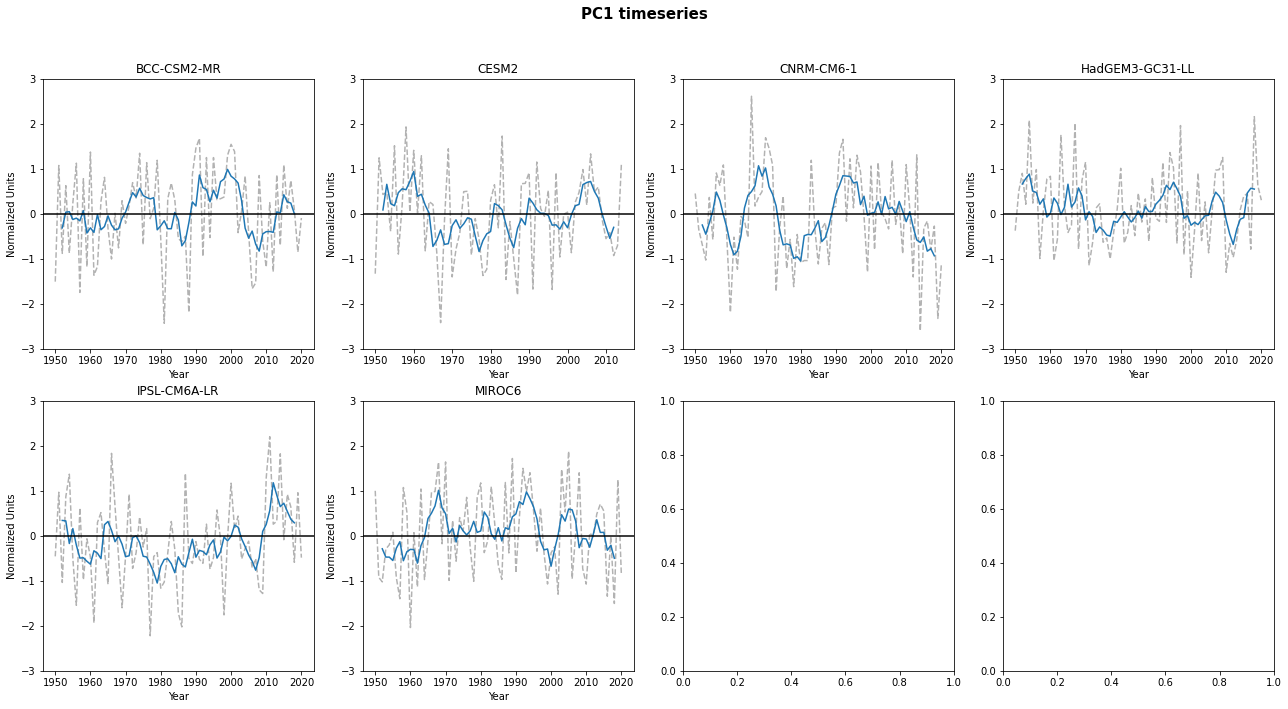

In [26]:
# Plot the leading PC time series.
fig, axs = plt.subplots(2,4,figsize=[18,10])
fig.suptitle('PC1 timeseries',fontsize=15,weight='bold')
m=0
n=0
switched = ['CESM2', 'CNRM-CM6-1', 'MIROC6']
bad_models = ['CanESM5']
model_nao=pd.DataFrame()
for i in range(0,7):
  if common_models[i] not in bad_models:
    if common_models[i] in switched:
      if common_models[i] == 'CESM2':
        y = list(range(1900,2015))
      else:
        y = list(range(1900,2021))
      factor = -1
    else:
      y = list(range(1900,2021))
      factor = 1
    eof_data = get_EOF(common_models[i])
    try:
      model_nao[common_models[i]]=factor*eof_data[1][50:]
    except:
      pass
    axs[n,m].plot(y[50:],pd.DataFrame(factor*eof_data[1][50:]),'k--',alpha=0.3)
    axs[n,m].plot(y[50:],pd.DataFrame(factor*eof_data[1][50:]).rolling(window=5,center=True).mean())
    axs[n,m].set_title(common_models[i])
    axs[n,m].axhline(0, color='k')
    axs[n,m].set_ylim(-3, 3)
    axs[n,m].set_xlabel('Year')
    axs[n,m].set_ylabel('Normalized Units')
    m=m+1
    if m>3:
      m=0
      n=n+1
    else:
      continue
plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [27]:
model_nao.columns

Index(['BCC-CSM2-MR', 'CNRM-CM6-1', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR',
       'MIROC6'],
      dtype='object')

Text(0, 0.5, 'Normalized Units')

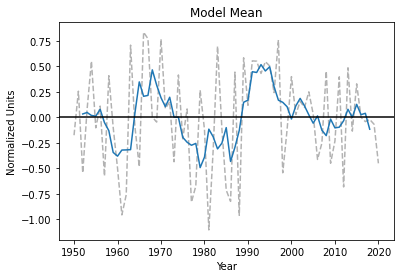

In [28]:
## Plotting model mean (5 models)
plt.plot(y[50:],model_nao.T.mean(),'k--',alpha=0.3)
plt.plot(y[50:],model_nao.T.mean().rolling(window=5,center=True).mean())
plt.title('Model Mean')
plt.axhline(0, color='k')
# plt.ylim(-3, 3)
plt.xlabel('Year')
plt.ylabel('Normalized Units')

In [0]:
# model_nao.to_csv('asd.csv',index=False)
# from google.colab import files
# files.download("asd.csv")